In [1]:
import os
import random
import warnings

# Dataframe
import pandas as pd
import numpy as np
from itertools import combinations
import matplotlib.pyplot as plt

from prophet import Prophet
from prophet.diagnostics import cross_validation
from prophet.diagnostics import performance_metrics
from sklearn.metrics import mean_squared_error

import optuna
from optuna import Trial

warnings.filterwarnings('ignore')

/home/yeeun/anaconda3/envs/tsf-spi/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.


In [2]:
data = pd.read_csv('../data/kospi.csv').dropna()
data

,Date,Kospi,USD/KRW,GDP,IAIP,LIR,M1,disease
0,2010-01-04,1696.140015,1132.400024,1143.67,79.3,5.350,59.71815,0
1,2010-01-05,1690.619995,1141.300049,1143.67,79.3,5.350,59.71815,0
2,2010-01-06,1705.319946,1130.400024,1143.67,79.3,5.350,59.71815,0
3,2010-01-07,1683.449951,1134.900024,1143.67,79.3,5.350,59.71815,0
4,2010-01-08,1695.260010,1123.099976,1143.67,79.3,5.350,59.71815,0
...,...,...,...,...,...,...,...,...
3509,2024-04-01,2747.860107,1345.310059,1673.92,105.5,3.353,187.20330,0
3510,2024-04-02,2753.159912,1355.530029,1673.92,105.5,3.353,187.20330,0
3511,2024-04-03,2706.969971,1350.729980,1673.92,105.5,3.353,187.20330,0
3512,2024-04-04,2742.000000,1344.839966,1673.92,105.5,3.353,187.20330,0


In [3]:
split_date = '2021-12-31'

# train, valid, test 데이터 나누기
train_data = data.loc[data['Date'] <= split_date].copy()
test_data = data.loc[data['Date'] > split_date].copy()

In [4]:
print("Train 데이터 크기:", len(train_data))
print("Test 데이터 크기:", len(test_data))

Train 데이터 크기: 2959
Test 데이터 크기: 555


In [5]:
data.rename(columns={'Date': 'ds', 'Kospi': 'y'}, inplace=True)
data['ds'] = pd.to_datetime(data['ds'])

train_data.rename(columns={'Date': 'ds', 'Kospi': 'y'}, inplace=True)
train_data['ds'] = pd.to_datetime(train_data['ds'])

test_data.rename(columns={'Date': 'ds', 'Kospi': 'y'}, inplace=True)
test_data['ds'] = pd.to_datetime(test_data['ds'])

In [6]:
regressor_columns = ['USD/KRW', 'GDP', 'IAIP', 'LIR', 'M1', 'disease']

# 가능한 모든 조합의 리스트 생성
all_combinations = []
for r in range(1, len(regressor_columns) + 1):
    all_combinations.extend(combinations(regressor_columns, r))

regressor_combinations = ['_'.join(combination) for combination in all_combinations]

In [15]:
def train(train_data, changepoints, changepoints_range, seasonality_mode, growth, regressors, cap=None):
    """
    train_data: train data
    changepoints: changepoints
    changepoints_range: changepoints_range
    seasonality_mode: seasonality_mode
    growth: growth
    regressors: regressors
    cap: cap
    """
    # Changepoints 랜덤 생성
    changepoints = sorted(random.sample(list(train_data['ds']), changepoints))

    if growth == 'logistic':
        train_data['cap'] = cap  # 용량 값 설정
    
    model = Prophet(
        changepoints=changepoints,
        changepoint_range=changepoints_range,
        seasonality_mode=seasonality_mode,
        growth=growth,
    )
    
    columns = regressors.split('_')
    
    for col in columns:
        model.add_regressor(col)
    
    model.fit(train_data)
    train_cv = cross_validation(model, initial=f'730 days', period='90 days', horizon='30 days')
    train_p = performance_metrics(train_cv)
    
    return model, train_cv, train_p

In [8]:
def test(model: Prophet, test_data, regressors=[], growth='', cap=0, **kwargs):
    columns = regressors.split('_')
    
    # 예측 및 평가
    future = model.make_future_dataframe(periods=len(test_data), include_history=False)
    
    for col in columns:
        future[col] = test_data[col].values
        
    if growth == 'logistic':
        future['cap'] = cap  # 용량 값 설정
    
    forecast = model.predict(future)
    rmse = np.sqrt(mean_squared_error(test_data["y"], forecast["yhat"]))

    return rmse, forecast

In [10]:
params = {'changepoints': 1, 'changepoints_range': 0.8734798313148161, 'seasonality_mode': 'additive', 'growth': 'linear', 'regressors': 'USD/KRW_GDP_LIR_M1'}

model, train_cv, train_p = train(train_data, **params)

00:48:43 - cmdstanpy - INFO - Chain [1] start processing
00:48:43 - cmdstanpy - INFO - Chain [1] done processing


In [11]:
train_cv

NameError: name 'train_cv' is not defined

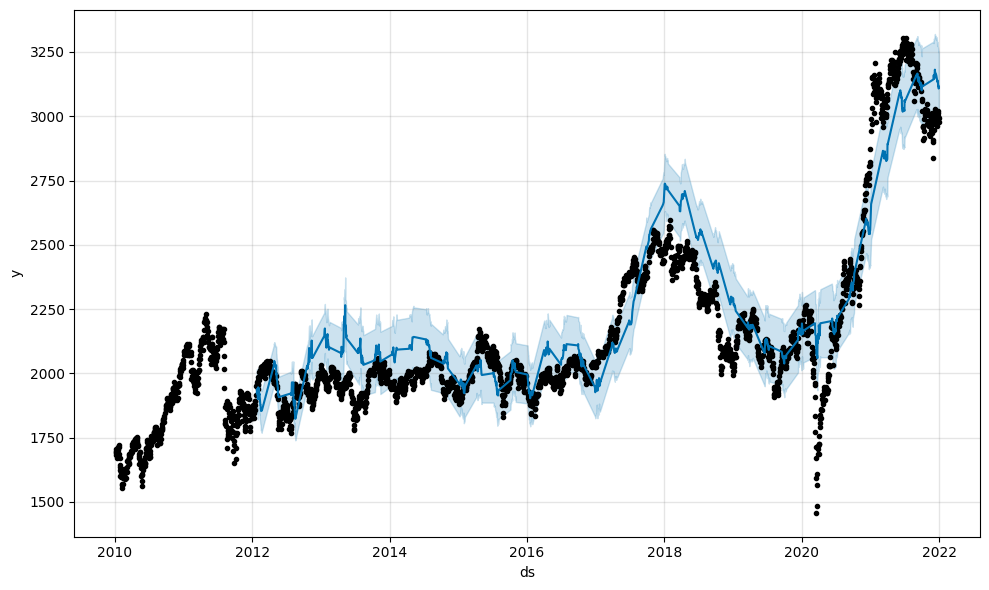

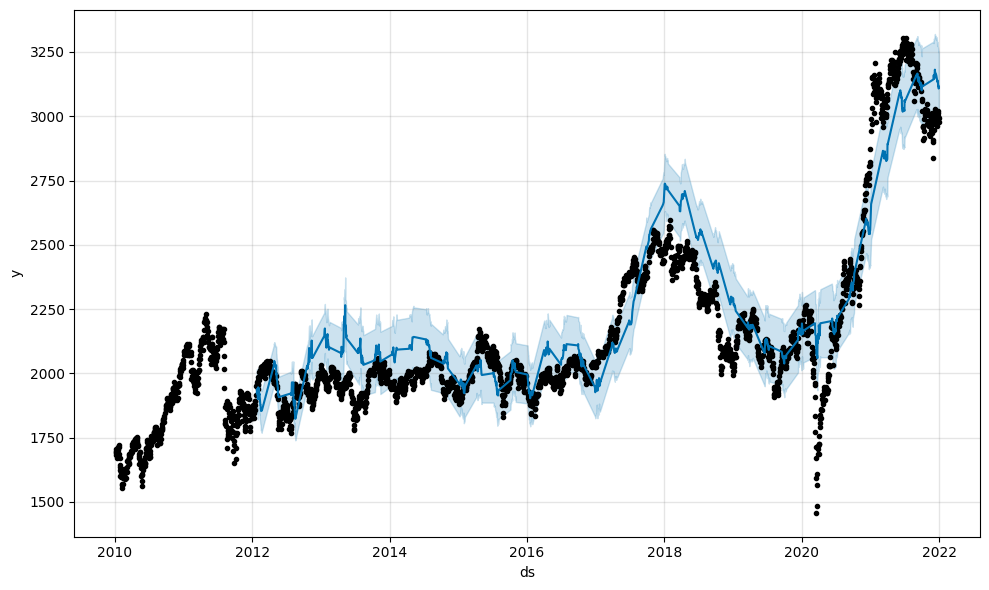

In [ ]:
model.plot(train_cv)

In [ ]:
train_p

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,3 days,18354.326827,135.478142,108.016208,0.050469,0.042940,0.048904,0.591463
1,4 days,16126.350662,126.989569,100.713467,0.047024,0.039629,0.045804,0.643728
2,5 days,14451.938315,120.216215,98.157069,0.045399,0.039629,0.044419,0.626577
3,6 days,16332.479911,127.798591,105.167827,0.048249,0.045928,0.047110,0.560976
4,7 days,19706.298104,140.379123,114.540044,0.053164,0.052605,0.051474,0.521138
5,8 days,23058.421975,151.849998,121.601565,0.057696,0.050602,0.055401,0.530923
6,9 days,25013.288047,158.155898,120.550341,0.058769,0.049161,0.055996,0.573171
7,10 days,25789.101301,160.589854,119.977295,0.058809,0.048315,0.056056,0.591899
8,11 days,22573.426499,150.244556,112.418837,0.053975,0.046954,0.051995,0.629178
9,12 days,18528.821346,136.120613,106.761634,0.049142,0.046496,0.048072,0.639115


In [ ]:
print("RMSE: ", round(train_p["rmse"].mean(),1))
print("MAPE: ", 100 * round(train_p["mape"].mean(),3), "%")

RMSE:  150.1
MAPE:  5.5 %


In [12]:
rmse, forecast = test(model, test_data, **params)

In [13]:
def plot_stock_forecast(data, forecast):
    plt.figure(figsize=(12, 6))
    plt.plot(forecast['ds'], forecast['yhat'], label='Predicted', color='red')
    plt.plot(pd.to_datetime(data['ds']), data['y'], label='Actual', color='blue')
    plt.fill_between(forecast['ds'], forecast['yhat_lower'], forecast['yhat_upper'], color='pink', alpha=0.5)
    plt.title('Stock Price Forecast')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.show()

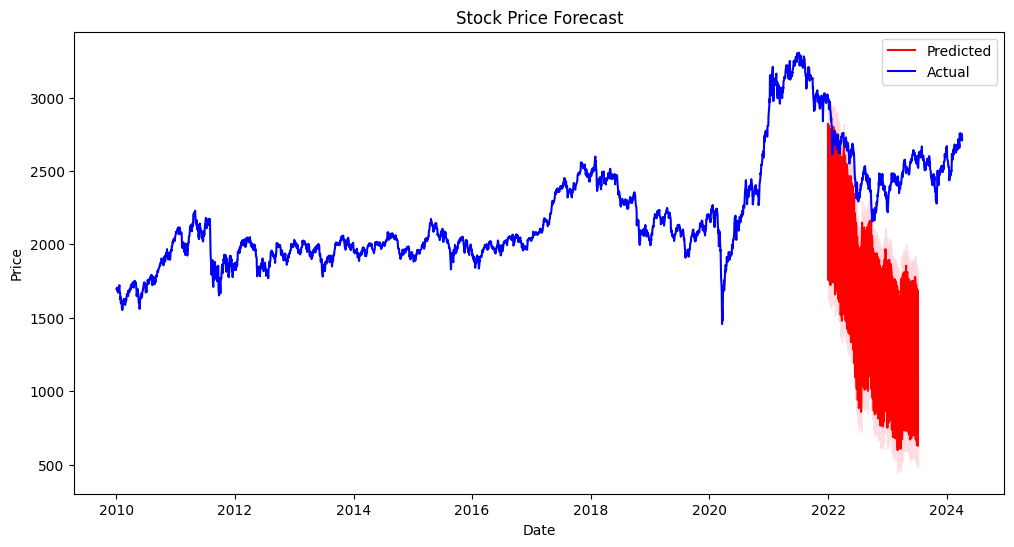

In [14]:
plot_stock_forecast(data, forecast)